# Los Angeles Crime Data Analysis (2020-2025)

## Table of Contents
1. Data Loading and Initial Overview
2. Data Cleaning
   - Identify Outliers
   - Remove Outliers
   - Drop Redundant Columns
3. Descriptive Statistics (Cleaned Data)
4. Exploratory Data Analysis (Cleaned Data)
5. Summary

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print('✓ Libraries loaded')

✓ Libraries loaded


## 1. Data Loading and Initial Overview

In [2]:
# Load dataset
df = pd.read_csv('Crime_Data_from_2020_to_Present.csv')

print(f'Dataset loaded: {len(df):,} records, {len(df.columns)} columns')
print(f'Date range: {df["DATE OCC"].min()} to {df["DATE OCC"].max()}')

Dataset loaded: 1,004,991 records, 28 columns
Date range: 01/01/2020 12:00:00 AM to 12/31/2023 12:00:00 AM


In [3]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1004991 non-null  int64  
 1   Date Rptd       1004991 non-null  object 
 2   DATE OCC        1004991 non-null  object 
 3   TIME OCC        1004991 non-null  int64  
 4   AREA            1004991 non-null  int64  
 5   AREA NAME       1004991 non-null  object 
 6   Rpt Dist No     1004991 non-null  int64  
 7   Part 1-2        1004991 non-null  int64  
 8   Crm Cd          1004991 non-null  int64  
 9   Crm Cd Desc     1004991 non-null  object 
 10  Mocodes         853372 non-null   object 
 11  Vict Age        1004991 non-null  int64  
 12  Vict Sex        860347 non-null   object 
 13  Vict Descent    860335 non-null   object 
 14  Premis Cd       1004975 non-null  float64
 15  Premis Desc     1004403 non-null  object 
 16  Weapon Used Cd  327247 non-null   fl

In [4]:
# Preview
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,7800 BEEMAN AV,NaN,34.2124,-118.4092
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,NaN,NaN,NaN,ATOLL AV,N GAULT,34.1993,-118.4203
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,14600 SYLVAN ST,NaN,34.1847,-118.4509
3,210704711,12/24/2020 12:00:00 AM,12/24/2020 12:00:00 AM,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331.0,NaN,NaN,NaN,6000 COMEY AV,NaN,34.0339,-118.3747
4,201418201,10/03/2020 12:00:00 AM,09/29/2020 12:00:00 AM,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,NaN,NaN,NaN,4700 LA VILLA MARINA,NaN,33.9813,-118.4350


## 2. Data Cleaning

### 2.1 Parse Temporal Features

In [5]:
# Parse dates
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'], errors='coerce')

# Create temporal features
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month
df['Day'] = df['DATE OCC'].dt.day
df['DayOfWeek'] = df['DATE OCC'].dt.dayofweek
df['DayName'] = df['DATE OCC'].dt.day_name()
df['Hour'] = (df['TIME OCC'] // 100).astype('Int64')
df['Report_Delay_Days'] = (df['Date Rptd'] - df['DATE OCC']).dt.days

print('✓ Temporal features created')

✓ Temporal features created


### 2.2 Identify Outliers

**Outliers to identify and remove:**
1. Victim Age < 0 or > 100
2. Coordinates (0, 0)

In [6]:
print('OUTLIER DETECTION')
print('='*60)

# 1. Victim Age outliers
print('\n1. Victim Age Outliers:')
print(f'   Total records: {len(df):,}')
print(f'   Age range: {df["Vict Age"].min()} to {df["Vict Age"].max()}')
print(f'\n   Outliers:')
age_negative = (df['Vict Age'] < 0).sum()
age_over_100 = (df['Vict Age'] > 100).sum()
print(f'   - Negative ages: {age_negative:,}')
if age_negative > 0:
    print(f'     Values: {df[df["Vict Age"] < 0]["Vict Age"].value_counts().to_dict()}')
print(f'   - Age > 100: {age_over_100:,}')
if age_over_100 > 0:
    print(f'     Values: {df[df["Vict Age"] > 100]["Vict Age"].value_counts().to_dict()}')

age_outliers = age_negative + age_over_100
print(f'\n   → Total age outliers to remove: {age_outliers:,}')

# 2. Coordinate outliers
print('\n2. Coordinate Outliers:')
coord_outliers = ((df['LAT'] == 0) & (df['LON'] == 0)).sum()
print(f'   - Coordinates (0, 0): {coord_outliers:,} ({coord_outliers/len(df)*100:.2f}%)')
print(f'   - These are missing/unknown locations')
print(f'\n   → Total coordinate outliers to remove: {coord_outliers:,}')

print(f'\n' + '='*60)
print(f'TOTAL OUTLIERS TO REMOVE: {age_outliers + coord_outliers:,}')
print(f'Percentage of dataset: {(age_outliers + coord_outliers)/len(df)*100:.2f}%')
print('='*60)

OUTLIER DETECTION

1. Victim Age Outliers:
   Total records: 1,004,991
   Age range: -4 to 120

   Outliers:
   - Negative ages: 137
     Values: {-1: 100, -2: 28, -3: 6, -4: 3}
   - Age > 100: 1
     Values: {120: 1}

   → Total age outliers to remove: 138

2. Coordinate Outliers:
   - Coordinates (0, 0): 2,240 (0.22%)
   - These are missing/unknown locations

   → Total coordinate outliers to remove: 2,240

TOTAL OUTLIERS TO REMOVE: 2,378
Percentage of dataset: 0.24%


### 2.3 Remove Outliers

In [7]:
print('REMOVING OUTLIERS...')
print('='*60)

df_clean = df.copy()
initial_count = len(df_clean)

# Remove age outliers
age_mask = (df_clean['Vict Age'] >= 0) & (df_clean['Vict Age'] <= 100)
df_clean = df_clean[age_mask]
after_age = len(df_clean)
print(f'✓ Removed {initial_count - after_age:,} age outliers')
print(f'  Remaining: {after_age:,} records')

# Remove coordinate outliers
coord_mask = ~((df_clean['LAT'] == 0) & (df_clean['LON'] == 0))
df_clean = df_clean[coord_mask]
after_coord = len(df_clean)
print(f'✓ Removed {after_age - after_coord:,} coordinate outliers')
print(f'  Remaining: {after_coord:,} records')

print('\n' + '='*60)
print(f'CLEANED DATASET: {len(df_clean):,} records')
print(f'Removed: {initial_count - len(df_clean):,} records ({(initial_count - len(df_clean))/initial_count*100:.2f}%)')
print('='*60)

REMOVING OUTLIERS...
✓ Removed 138 age outliers
  Remaining: 1,004,853 records
✓ Removed 2,240 coordinate outliers
  Remaining: 1,002,613 records

CLEANED DATASET: 1,002,613 records
Removed: 2,378 records (0.24%)


### 2.4 Verify Cleaning

In [8]:
# Verify no outliers remain
print('VERIFICATION:')
print(f'  Age range: {df_clean["Vict Age"].min()} to {df_clean["Vict Age"].max()}')
print(f'  Age < 0: {(df_clean["Vict Age"] < 0).sum()}')
print(f'  Age > 100: {(df_clean["Vict Age"] > 100).sum()}')
print(f'  Coordinates (0,0): {((df_clean["LAT"] == 0) & (df_clean["LON"] == 0)).sum()}')
print('\n✓ All outliers removed successfully')

VERIFICATION:
  Age range: 0 to 99
  Age < 0: 0
  Age > 100: 0
  Coordinates (0,0): 0

✓ All outliers removed successfully


### 2.5 Create New Features and Drop Redundant Columns

In [9]:
# Create binary weapon feature
df_clean['Weapon_Involved'] = df_clean['Weapon Used Cd'].notna().astype(int)
print(f'✓ Created Weapon_Involved')
print(f'  - Weapon: {(df_clean["Weapon_Involved"]==1).sum():,} ({(df_clean["Weapon_Involved"]==1).sum()/len(df_clean)*100:.1f}%)')
print(f'  - No weapon: {(df_clean["Weapon_Involved"]==0).sum():,} ({(df_clean["Weapon_Involved"]==0).sum()/len(df_clean)*100:.1f}%)')

# Create victim type indicator
df_clean['Is_Personal_Victim'] = ((df_clean['Vict Age'] > 0) & 
                                   (df_clean['Vict Sex'].isin(['M', 'F']))).astype(int)
print(f'\n✓ Created Is_Personal_Victim')
print(f'  - Personal: {(df_clean["Is_Personal_Victim"]==1).sum():,} ({(df_clean["Is_Personal_Victim"]==1).sum()/len(df_clean)*100:.1f}%)')
print(f'  - Institutional: {(df_clean["Is_Personal_Victim"]==0).sum():,} ({(df_clean["Is_Personal_Victim"]==0).sum()/len(df_clean)*100:.1f}%)')

# Drop redundant columns
cols_to_drop = ['Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4']
df_clean = df_clean.drop(columns=cols_to_drop)
print(f'\n✓ Dropped {len(cols_to_drop)} redundant columns: {cols_to_drop}')

print(f'\n✓ Final cleaned dataset: {len(df_clean):,} records × {len(df_clean.columns)} features')

✓ Created Weapon_Involved
  - Weapon: 326,402 (32.6%)
  - No weapon: 676,211 (67.4%)

✓ Created Is_Personal_Victim
  - Personal: 723,302 (72.1%)
  - Institutional: 279,311 (27.9%)

✓ Dropped 4 redundant columns: ['Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4']

✓ Final cleaned dataset: 1,002,613 records × 33 features


In [10]:
# Before/After comparison
comparison = pd.DataFrame({
    'Metric': [
        'Total Records',
        'Total Columns',
        'Age Range',
        'Valid Coordinates',
        'Crime Types',
        'Geographic Areas'
    ],
    'Original': [
        f"{len(df):,}",
        f"{len(df.columns)}",
        f"{df['Vict Age'].min()} to {df['Vict Age'].max()}",
        f"{((df['LAT'] != 0) | (df['LON'] != 0)).sum():,}",
        f"{df['Crm Cd Desc'].nunique()}",
        f"{df['AREA NAME'].nunique()}"
    ],
    'Cleaned': [
        f"{len(df_clean):,}",
        f"{len(df_clean.columns)}",
        f"{df_clean['Vict Age'].min()} to {df_clean['Vict Age'].max()}",
        f"{len(df_clean):,} (100%)",
        f"{df_clean['Crm Cd Desc'].nunique()}",
        f"{df_clean['AREA NAME'].nunique()}"
    ]
})

print('\nBEFORE/AFTER COMPARISON:')
comparison


BEFORE/AFTER COMPARISON:


,Metric,Original,Cleaned
0,Total Records,"1,004,991","1,002,613"
1,Total Columns,35,33
2,Age Range,-4 to 120,0 to 99
3,Valid Coordinates,"1,002,751","1,002,613 (100%)"
4,Crime Types,140,140
5,Geographic Areas,21,21


## 3. Descriptive Statistics (Cleaned Data)

### 3.1 Temporal Distribution

Crimes by Year (Cleaned Data):
  2020: 199,014
  2021: 208,383
  2022: 235,216
  2023: 232,336
  2024: 127,567
  2025: 97


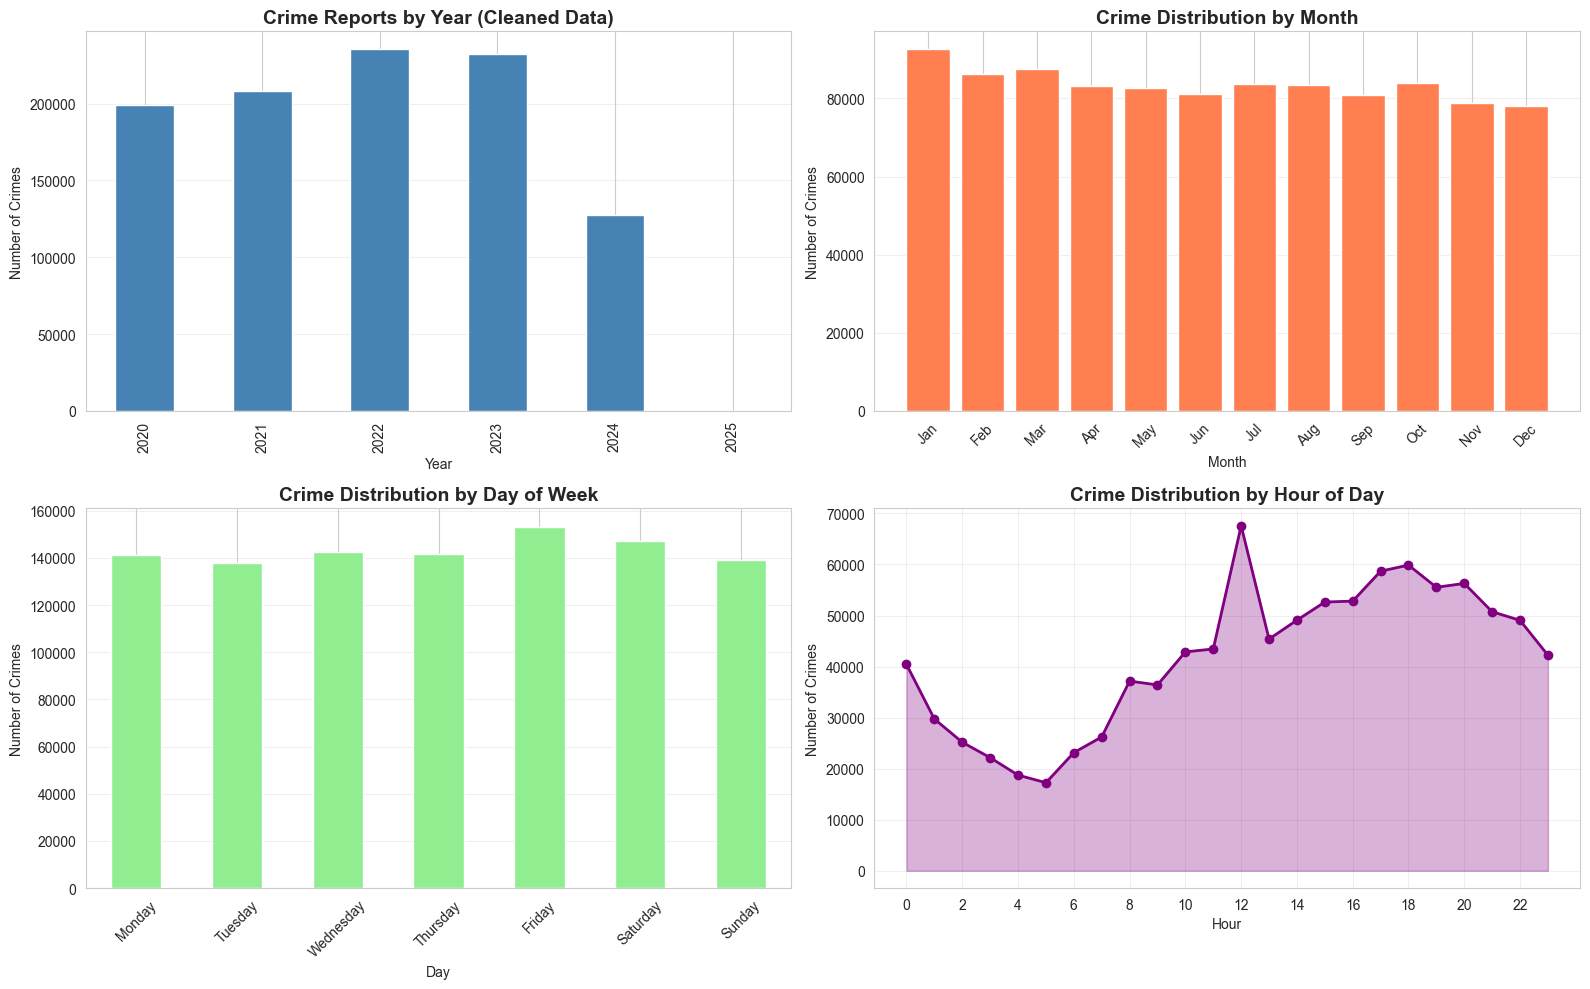


✓ Saved: temporal_distribution_cleaned.png


In [11]:
# Annual distribution
annual_crimes = df_clean['Year'].value_counts().sort_index()
print('Crimes by Year (Cleaned Data):')
for year, count in annual_crimes.items():
    print(f'  {year}: {count:,}')

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Annual trends
annual_crimes.plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Crime Reports by Year (Cleaned Data)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Number of Crimes')
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Monthly distribution
monthly_crimes = df_clean['Month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0,1].bar(range(1, 13), [monthly_crimes.get(i, 0) for i in range(1, 13)], color='coral')
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels(month_names, rotation=45)
axes[0,1].set_title('Crime Distribution by Month', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Number of Crimes')
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Day of week
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_crimes = df_clean['DayName'].value_counts().reindex(dow_names)
dow_crimes.plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Crime Distribution by Day of Week', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Day')
axes[1,0].set_ylabel('Number of Crimes')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# 4. Hourly distribution
hourly_crimes = df_clean[(df_clean['Hour'] >= 0) & (df_clean['Hour'] <= 23)].groupby('Hour').size()
axes[1,1].plot(hourly_crimes.index, hourly_crimes.values, marker='o', linewidth=2, color='purple')
axes[1,1].fill_between(hourly_crimes.index, hourly_crimes.values, alpha=0.3, color='purple')
axes[1,1].set_title('Crime Distribution by Hour of Day', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Hour')
axes[1,1].set_ylabel('Number of Crimes')
axes[1,1].set_xticks(range(0, 24, 2))
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_distribution_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Saved: temporal_distribution_cleaned.png')

### 3.2 Geographic Distribution

Top 10 Areas (Cleaned Data):
   1. Central                         69,462 ( 6.93%)
   2. 77th Street                     61,624 ( 6.15%)
   3. Pacific                         59,335 ( 5.92%)
   4. Southwest                       57,375 ( 5.72%)
   5. Hollywood                       52,101 ( 5.20%)
   6. N Hollywood                     51,011 ( 5.09%)
   7. Olympic                         49,927 ( 4.98%)
   8. Southeast                       49,790 ( 4.97%)
   9. Newton                          49,072 ( 4.89%)
  10. Wilshire                        48,099 ( 4.80%)

Top 10 Premise Types:
   1. STREET                                             260,889 (26.02%)
   2. SINGLE FAMILY DWELLING                             163,220 (16.28%)
   3. MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)       118,674 (11.84%)
   4. PARKING LOT                                         69,049 ( 6.89%)
   5. OTHER BUSINESS                                      47,493 ( 4.74%)
   6. SIDEWALK                        

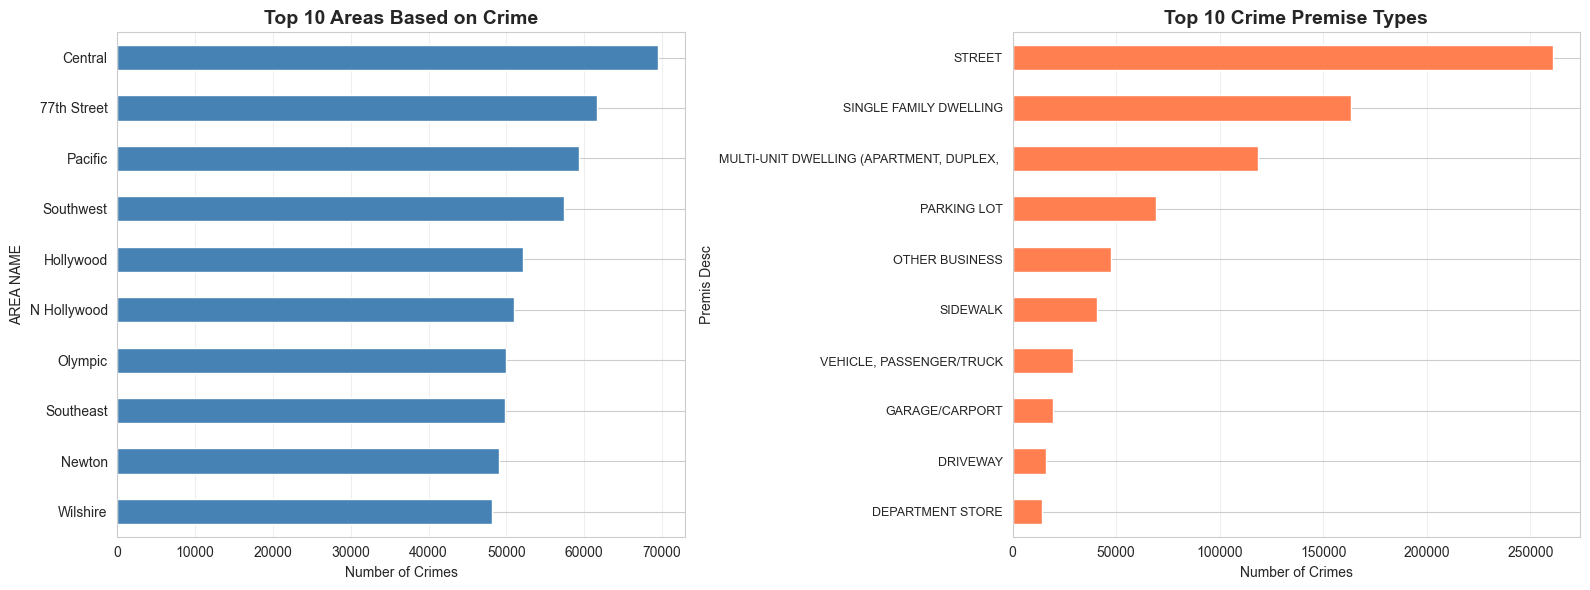


✓ Saved: geographic_distribution_cleaned.png


In [12]:
# Top 10 areas
top_areas = df_clean['AREA NAME'].value_counts().head(10)
print('Top 10 Areas (Cleaned Data):')
for i, (area, count) in enumerate(top_areas.items(), 1):
    pct = count / len(df_clean) * 100
    print(f'  {i:2d}. {area:30s} {count:7,} ({pct:5.2f}%)')

# Premise types
top_premises = df_clean['Premis Desc'].value_counts().head(10)
print('\nTop 10 Premise Types:')
for i, (premise, count) in enumerate(top_premises.items(), 1):
    pct = count / len(df_clean) * 100
    print(f'  {i:2d}. {premise:50s} {count:7,} ({pct:5.2f}%)')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_areas.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 10 Areas Based on Crime', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Crimes')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

top_premises.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Top 10 Crime Premise Types', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Crimes')
axes[1].set_yticklabels([label[:40] for label in top_premises.index], fontsize=9)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('geographic_distribution_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Saved: geographic_distribution_cleaned.png')

### 3.3 Crime Type Distribution

Top 15 Crime Types (Cleaned Data):
   1. VEHICLE - STOLEN                                             115,132 (11.48%)
   2. BATTERY - SIMPLE ASSAULT                                      74,483 ( 7.43%)
   3. BURGLARY FROM VEHICLE                                         63,462 ( 6.33%)
   4. THEFT OF IDENTITY                                             62,497 ( 6.23%)
   5. VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       61,018 ( 6.09%)
   6. BURGLARY                                                      57,849 ( 5.77%)
   7. THEFT PLAIN - PETTY ($950 & UNDER)                            53,591 ( 5.35%)
   8. ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                53,503 ( 5.34%)
   9. INTIMATE PARTNER - SIMPLE ASSAULT                             46,488 ( 4.64%)
  10. THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)               41,266 ( 4.12%)
  11. THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)           36,907 ( 3.68%)
  12. THEFT-GRAND ($950.01 & OVER)EXCPT,G

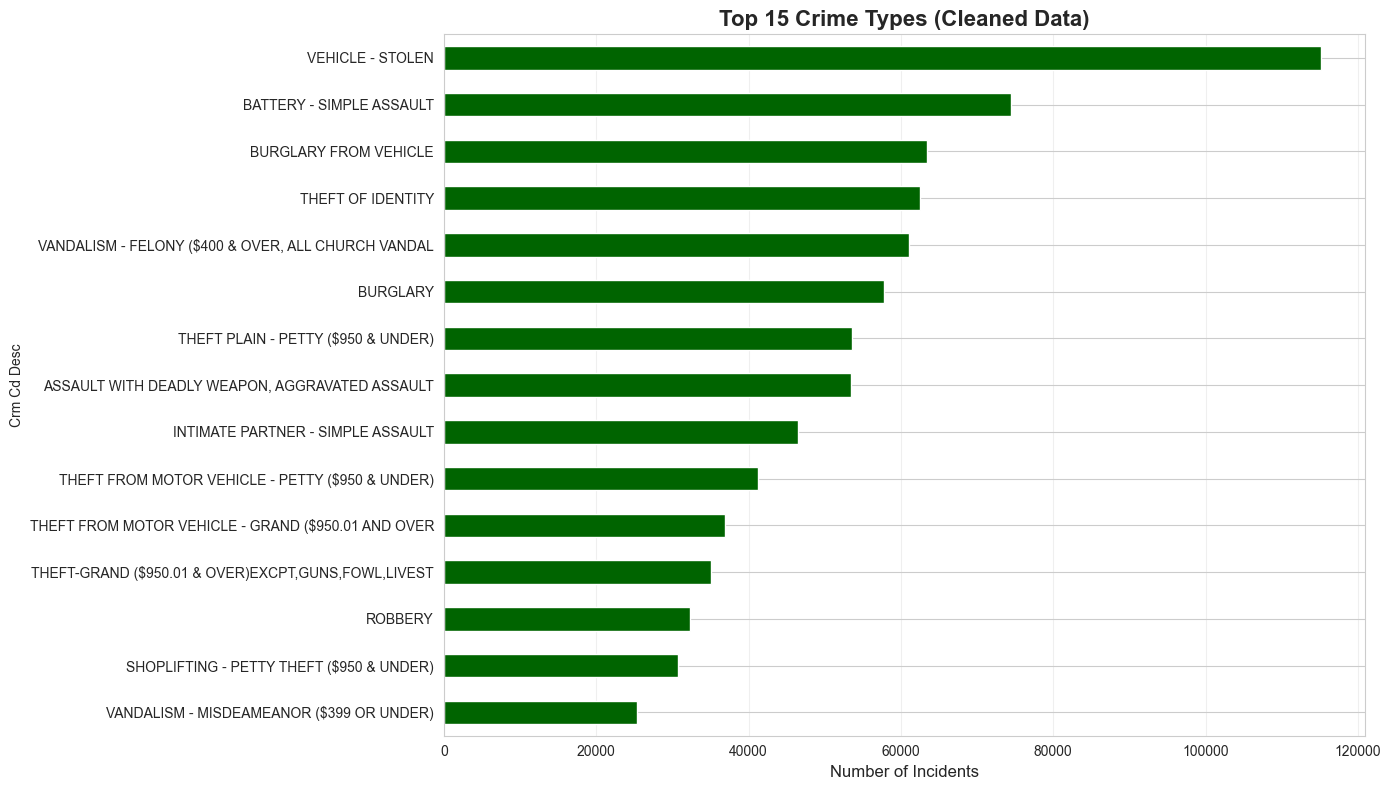


✓ Saved: crime_types_cleaned.png


In [13]:
# Top 15 crime types
top_crimes = df_clean['Crm Cd Desc'].value_counts().head(15)
print('Top 15 Crime Types (Cleaned Data):')
for i, (crime, count) in enumerate(top_crimes.items(), 1):
    pct = count / len(df_clean) * 100
    print(f'  {i:2d}. {crime:60s} {count:7,} ({pct:5.2f}%)')

print(f'\nTotal unique crime types: {df_clean["Crm Cd Desc"].nunique()}')

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
top_crimes.plot(kind='barh', ax=ax, color='darkgreen')
ax.set_title('Top 15 Crime Types (Cleaned Data)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Incidents', fontsize=12)
ax.set_yticklabels([label[:50] for label in top_crimes.index], fontsize=10)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('crime_types_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Saved: crime_types_cleaned.png')

### 3.4 Victim Demographics

Victim Analysis (Cleaned Data):
  Personal Victims: 723,302 (72.1%)
  Institutional Victims: 279,311 (27.9%)

Personal Victim Age Statistics:
  Mean: 39.7 years
  Median: 37.0 years
  Min: 2 years
  Max: 99 years
  Std Dev: 15.5 years

Victim Sex Distribution:
  M: 402,914 (40.2%)
  F: 357,671 (35.7%)
  X: 97,348 (9.7%)
  H: 114 (0.0%)
  -: 1 (0.0%)


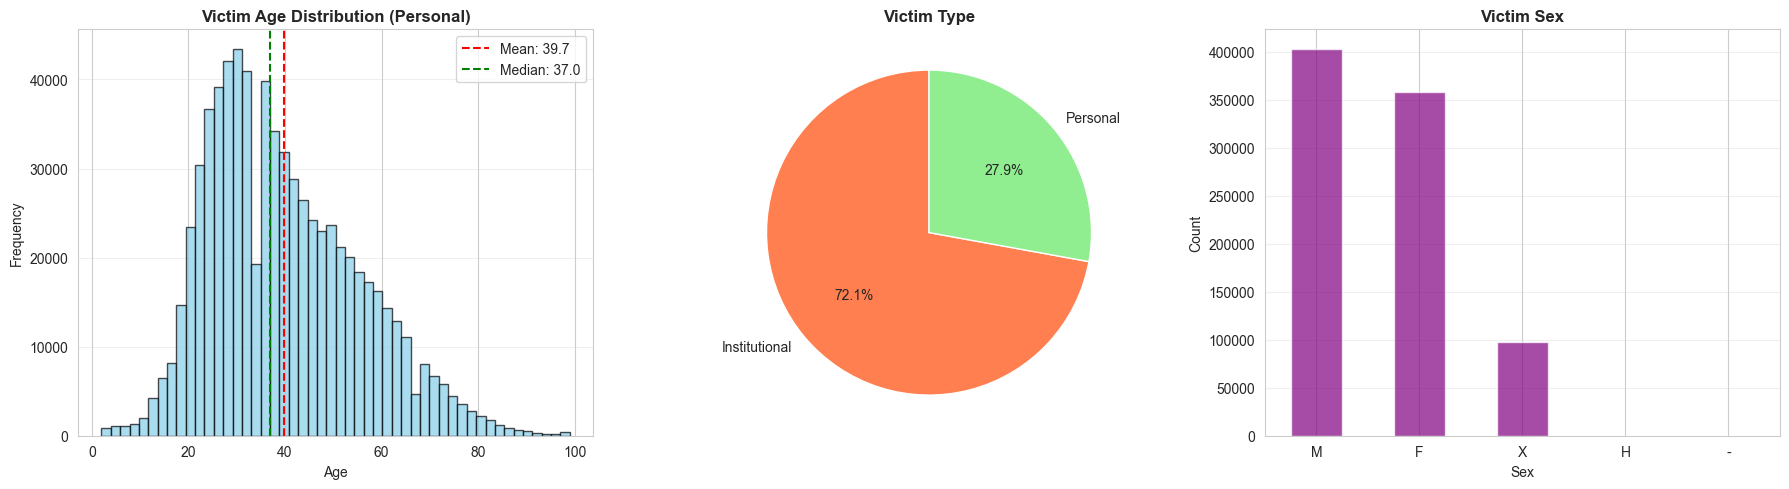


✓ Saved: victim_demographics_cleaned.png


In [14]:
# Personal vs institutional victims
personal_victims = df_clean[df_clean['Is_Personal_Victim'] == 1]
print(f'Victim Analysis (Cleaned Data):')
print(f'  Personal Victims: {len(personal_victims):,} ({len(personal_victims)/len(df_clean)*100:.1f}%)')
print(f'  Institutional Victims: {(df_clean["Is_Personal_Victim"] == 0).sum():,} ({(df_clean["Is_Personal_Victim"] == 0).sum()/len(df_clean)*100:.1f}%)')

print(f'\nPersonal Victim Age Statistics:')
print(f'  Mean: {personal_victims["Vict Age"].mean():.1f} years')
print(f'  Median: {personal_victims["Vict Age"].median():.1f} years')
print(f'  Min: {personal_victims["Vict Age"].min():.0f} years')
print(f'  Max: {personal_victims["Vict Age"].max():.0f} years')
print(f'  Std Dev: {personal_victims["Vict Age"].std():.1f} years')

# Sex distribution
print(f'\nVictim Sex Distribution:')
sex_dist = df_clean['Vict Sex'].value_counts().head(5)
for sex, count in sex_dist.items():
    pct = count / len(df_clean) * 100
    print(f'  {sex}: {count:,} ({pct:.1f}%)')

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Age distribution
axes[0].hist(personal_victims['Vict Age'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(personal_victims['Vict Age'].mean(), color='red', linestyle='--', 
                label=f'Mean: {personal_victims["Vict Age"].mean():.1f}')
axes[0].axvline(personal_victims['Vict Age'].median(), color='green', linestyle='--', 
                label=f'Median: {personal_victims["Vict Age"].median():.1f}')
axes[0].set_title('Victim Age Distribution (Personal)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 2. Personal vs institutional
victim_type = df_clean['Is_Personal_Victim'].value_counts()
axes[1].pie(victim_type.values, labels=['Institutional', 'Personal'], autopct='%1.1f%%', 
            startangle=90, colors=['coral', 'lightgreen'])
axes[1].set_title('Victim Type', fontsize=12, fontweight='bold')

# 3. Sex distribution
sex_dist.plot(kind='bar', ax=axes[2], color='purple', alpha=0.7)
axes[2].set_title('Victim Sex', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Sex')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=0)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('victim_demographics_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Saved: victim_demographics_cleaned.png')

### 3.5 Weapon and Case Status

Weapon Involvement (Cleaned Data):
  No weapon: 676,211 (67.4%)
  Weapon present: 326,402 (32.6%)

Top 10 Weapons:
   1. STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)     174,124 (53.35%)
   2. UNKNOWN WEAPON/OTHER WEAPON                        36,322 (11.13%)
   3. VERBAL THREAT                                      23,831 ( 7.30%)
   4. HAND GUN                                           20,175 ( 6.18%)
   5. SEMI-AUTOMATIC PISTOL                               7,258 ( 2.22%)
   6. KNIFE WITH BLADE 6INCHES OR LESS                    6,831 ( 2.09%)
   7. UNKNOWN FIREARM                                     6,576 ( 2.01%)
   8. OTHER KNIFE                                         5,870 ( 1.80%)
   9. MACE/PEPPER SPRAY                                   3,726 ( 1.14%)
  10. VEHICLE                                             3,260 ( 1.00%)

Case Status:
  Invest Cont          800,519 (79.84%)
  Adult Other          109,787 (10.95%)
  Adult Arrest          87,135 ( 8.69%)
  Juv Arrest        

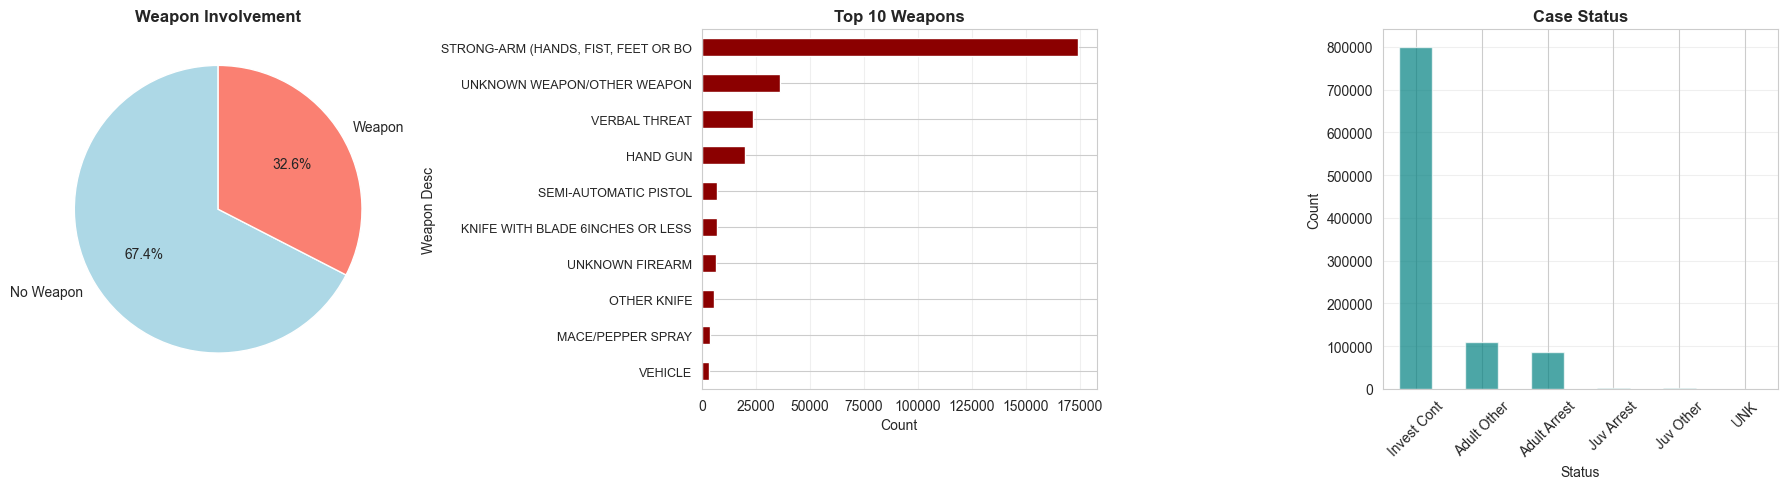


✓ Saved: weapon_status_cleaned.png


In [15]:
# Weapon involvement
weapon_counts = df_clean['Weapon_Involved'].value_counts()
print('Weapon Involvement (Cleaned Data):')
print(f'  No weapon: {weapon_counts[0]:,} ({weapon_counts[0]/len(df_clean)*100:.1f}%)')
print(f'  Weapon present: {weapon_counts[1]:,} ({weapon_counts[1]/len(df_clean)*100:.1f}%)')

# Top weapons
weapon_crimes = df_clean[df_clean['Weapon_Involved'] == 1]
top_weapons = weapon_crimes['Weapon Desc'].value_counts().head(10)
print(f'\nTop 10 Weapons:')
for i, (weapon, count) in enumerate(top_weapons.items(), 1):
    pct = count / len(weapon_crimes) * 100
    print(f'  {i:2d}. {weapon:50s} {count:6,} ({pct:5.2f}%)')

# Case status
print(f'\nCase Status:')
status_dist = df_clean['Status Desc'].value_counts()
for status, count in status_dist.items():
    pct = count / len(df_clean) * 100
    print(f'  {status:20s} {count:7,} ({pct:5.2f}%)')

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].pie(weapon_counts.values, labels=['No Weapon', 'Weapon'], 
            autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
axes[0].set_title('Weapon Involvement', fontsize=12, fontweight='bold')

top_weapons.plot(kind='barh', ax=axes[1], color='darkred')
axes[1].set_title('Top 10 Weapons', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].set_yticklabels([label[:35] for label in top_weapons.index], fontsize=9)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

status_dist.plot(kind='bar', ax=axes[2], color='teal', alpha=0.7)
axes[2].set_title('Case Status', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Status')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('weapon_status_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✓ Saved: weapon_status_cleaned.png')

## 4. Exploratory Data Analysis (Cleaned Data)

### 4.1 Crime Trends Over Time

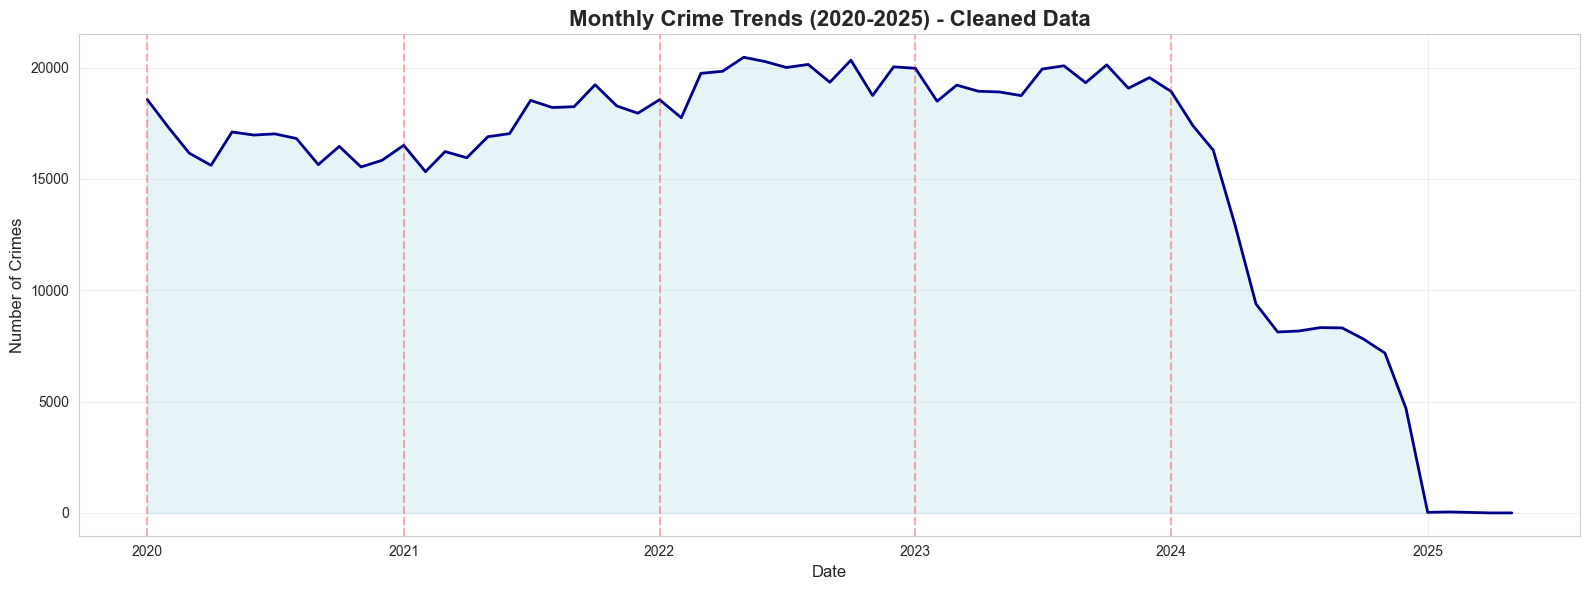

✓ Saved: crime_trends_cleaned.png


In [16]:
# Monthly trend
monthly_trend = df_clean.groupby(df_clean['DATE OCC'].dt.to_period('M')).size()
monthly_trend.index = monthly_trend.index.to_timestamp()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(monthly_trend.index, monthly_trend.values, linewidth=2, color='darkblue')
ax.fill_between(monthly_trend.index, monthly_trend.values, alpha=0.3, color='lightblue')
ax.set_title('Monthly Crime Trends (2020-2025) - Cleaned Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.grid(True, alpha=0.3)

# Add year markers
for year in [2020, 2021, 2022, 2023, 2024]:
    if year in df_clean['Year'].values:
        ax.axvline(pd.Timestamp(f'{year}-01-01'), color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('crime_trends_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Saved: crime_trends_cleaned.png')

### 4.2 Crime Heatmap (Day × Hour)

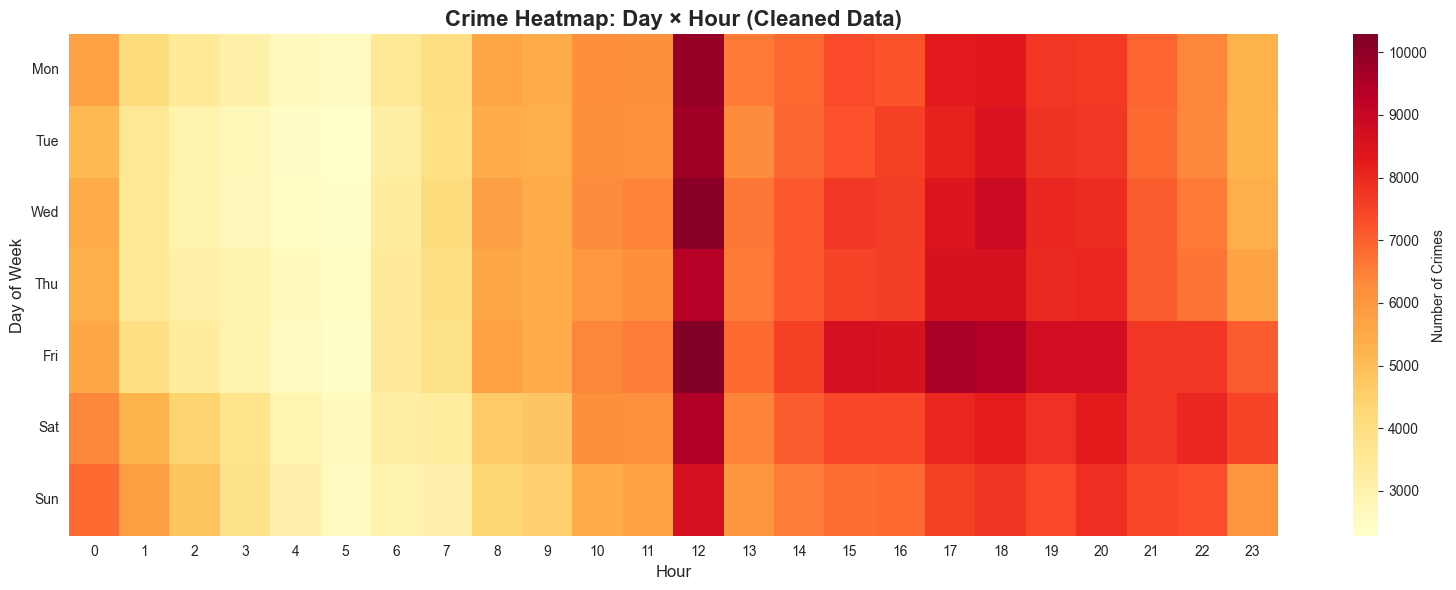

✓ Saved: crime_heatmap_cleaned.png


In [17]:
# Heatmap
dow_hour = df_clean[(df_clean['Hour'] >= 0) & (df_clean['Hour'] <= 23)].groupby(['DayOfWeek', 'Hour']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(dow_hour, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Number of Crimes'})
ax.set_title('Crime Heatmap: Day × Hour (Cleaned Data)', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

plt.tight_layout()
plt.savefig('crime_heatmap_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Saved: crime_heatmap_cleaned.png')

### 4.3 Personal vs Institutional Crimes

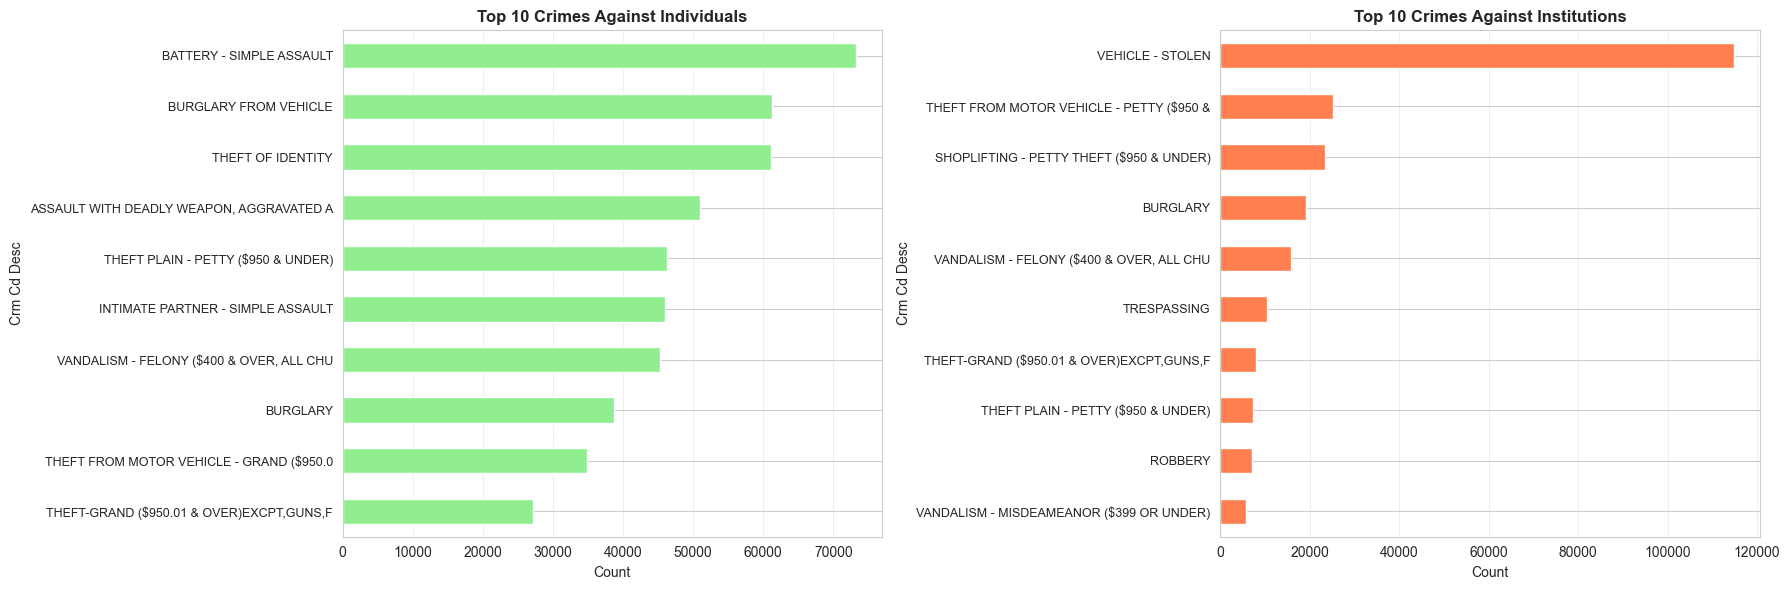

✓ Saved: personal_vs_institutional_cleaned.png


In [18]:
# Compare crime types
personal_crimes = df_clean[df_clean['Is_Personal_Victim'] == 1]['Crm Cd Desc'].value_counts().head(10)
institutional_crimes = df_clean[df_clean['Is_Personal_Victim'] == 0]['Crm Cd Desc'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

personal_crimes.plot(kind='barh', ax=axes[0], color='lightgreen')
axes[0].set_title('Top 10 Crimes Against Individuals', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].set_yticklabels([label[:40] for label in personal_crimes.index], fontsize=9)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

institutional_crimes.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Top 10 Crimes Against Institutions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].set_yticklabels([label[:40] for label in institutional_crimes.index], fontsize=9)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('personal_vs_institutional_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Saved: personal_vs_institutional_cleaned.png')

## 5. Summary

In [19]:
print('='*80)
print('DATA ANALYSIS SUMMARY (CLEANED DATA)')
print('='*80)

print('\n1. DATA CLEANING:')
print(f'   - Original records: {len(df):,}')
print(f'   - Outliers removed: {len(df) - len(df_clean):,} ({(len(df) - len(df_clean))/len(df)*100:.2f}%)')
print(f'     • Age outliers: {age_outliers:,}')
print(f'     • Coordinate outliers: {coord_outliers:,}')
print(f'   - Final dataset: {len(df_clean):,} records')
print(f'   - Columns dropped: 4 (Crm Cd 1/2/3/4)')
print(f'   - Features created: 2 (Weapon_Involved, Is_Personal_Victim)')

print('\n2. KEY FINDINGS:')
print(f'   - Date range: {df_clean["DATE OCC"].min().date()} to {df_clean["DATE OCC"].max().date()}')
print(f'   - Crime types: {df_clean["Crm Cd Desc"].nunique()}')
print(f'   - Geographic areas: {df_clean["AREA NAME"].nunique()}')
print(f'   - Peak year: {df_clean["Year"].value_counts().idxmax()} ({df_clean["Year"].value_counts().max():,} crimes)')
print(f'   - Most common crime: {df_clean["Crm Cd Desc"].value_counts().index[0]}')
print(f'     ({df_clean["Crm Cd Desc"].value_counts().iloc[0]:,} cases)')
print(f'   - Highest crime area: {df_clean["AREA NAME"].value_counts().index[0]}')
print(f'     ({df_clean["AREA NAME"].value_counts().iloc[0]:,} cases)')

print('\n3. VICTIM ANALYSIS:')
print(f'   - Personal victims: {(df_clean["Is_Personal_Victim"]==1).sum():,} ({(df_clean["Is_Personal_Victim"]==1).sum()/len(df_clean)*100:.1f}%)')
print(f'   - Institutional victims: {(df_clean["Is_Personal_Victim"]==0).sum():,} ({(df_clean["Is_Personal_Victim"]==0).sum()/len(df_clean)*100:.1f}%)')
print(f'   - Mean age (personal): {personal_victims["Vict Age"].mean():.1f} years')
print(f'   - Age range: {df_clean["Vict Age"].min():.0f} to {df_clean["Vict Age"].max():.0f} years')

print('\n4. WEAPON INVOLVEMENT:')
print(f'   - Crimes with weapons: {(df_clean["Weapon_Involved"]==1).sum():,} ({(df_clean["Weapon_Involved"]==1).sum()/len(df_clean)*100:.1f}%)')
print(f'   - Crimes without weapons: {(df_clean["Weapon_Involved"]==0).sum():,} ({(df_clean["Weapon_Involved"]==0).sum()/len(df_clean)*100:.1f}%)')

print('\n5. CASE STATUS:')
print(f'   - Under investigation: {(df_clean["Status Desc"]=="Invest Cont").sum():,} ({(df_clean["Status Desc"]=="Invest Cont").sum()/len(df_clean)*100:.1f}%)')
print(f'   - Adult arrests: {(df_clean["Status Desc"]=="Adult Arrest").sum():,} ({(df_clean["Status Desc"]=="Adult Arrest").sum()/len(df_clean)*100:.1f}%)')

print('\n6. GENERATED FILES:')
print('   1. temporal_distribution_cleaned.png')
print('   2. geographic_distribution_cleaned.png')
print('   3. crime_types_cleaned.png')
print('   4. victim_demographics_cleaned.png')
print('   5. weapon_status_cleaned.png')
print('   6. crime_trends_cleaned.png')
print('   7. crime_heatmap_cleaned.png')
print('   8. personal_vs_institutional_cleaned.png')
print('   9. crime_data_cleaned_final.csv')

print('\n' + '='*80)
print('✓ ANALYSIS COMPLETE')
print('='*80)

DATA ANALYSIS SUMMARY (CLEANED DATA)

1. DATA CLEANING:
   - Original records: 1,004,991
   - Outliers removed: 2,378 (0.24%)
     • Age outliers: 138
     • Coordinate outliers: 2,240
   - Final dataset: 1,002,613 records
   - Columns dropped: 4 (Crm Cd 1/2/3/4)
   - Features created: 2 (Weapon_Involved, Is_Personal_Victim)

2. KEY FINDINGS:
   - Date range: 2020-01-01 to 2025-05-29
   - Crime types: 140
   - Geographic areas: 21
   - Peak year: 2022 (235,216 crimes)
   - Most common crime: VEHICLE - STOLEN
     (115,132 cases)
   - Highest crime area: Central
     (69,462 cases)

3. VICTIM ANALYSIS:
   - Personal victims: 723,302 (72.1%)
   - Institutional victims: 279,311 (27.9%)
   - Mean age (personal): 39.7 years
   - Age range: 0 to 99 years

4. WEAPON INVOLVEMENT:
   - Crimes with weapons: 326,402 (32.6%)
   - Crimes without weapons: 676,211 (67.4%)

5. CASE STATUS:
   - Under investigation: 800,519 (79.8%)
   - Adult arrests: 87,135 (8.7%)

6. GENERATED FILES:
   1. temporal_d

## Save Cleaned Dataset

In [20]:
# Save cleaned dataset
df_clean.to_csv('crime_data_cleaned_final.csv', index=False)
print(f'✓ Saved: crime_data_cleaned_final.csv')
print(f'  - Records: {len(df_clean):,}')
print(f'  - Features: {len(df_clean.columns)}')

✓ Saved: crime_data_cleaned_final.csv
  - Records: 1,002,613
  - Features: 33


In [32]:
# ===================================
# DATA PREP FOR MODELING
# ===================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

model_df = df_clean.copy()
# Create a new column that determines if entry is on a weekend
model_df['Is_Weekend'] = model_df["DayOfWeek"].isin([5,6]).astype(int)
# Create a new column that determines if entry occurred within nightly hours (Between 8pm and 5am)
night_mask = (model_df['Hour'].between(20,23)) | (model_df['Hour'].between(0, 5))
model_df['Is_Night'] = night_mask.astype(int)

target_col = 'Crm Cd Desc'

feature_cols = [
    'Year',
    'Month',
    'DayOfWeek',
    'Hour',
    'AREA',
    'Premis Desc',
    'Vict Age',
    'Is_Personal_Victim',
    'Weapon_Involved',
    'Is_Weekend',
    'Is_Night'
]

# Determine classes of crimes and whether they occur at least twice, if any do not drop the crime type from the target column.
class_counts = model_df[target_col].value_counts()
valid_classes = class_counts[class_counts >= 2].index
model_df = model_df[model_df[target_col].isin(valid_classes)].copy()

print("Class Count Filter")
print(f"Number of crime classes before filtering: {len(class_counts)}")
print(f"Number of crime classes after filtering : {len(valid_classes)}")
print("")

# Set up the training
X = model_df[feature_cols].copy()
y = model_df[target_col].copy()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

class_names = label_encoder.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("Data Prep Results")
print(f"  - Total samples: {len(model_df):,}")
print(f"  - Train samples: {len(X_train):,}")
print(f"  - Test samples : {len(X_test):,}")
print(f"  - Number of features: {X_train.shape[1]}")
print(f"  - Number of crime classes: {len(class_names)}")


Class Count Filter
Number of crime classes before filtering: 140
Number of crime classes after filtering : 138

Data Prep Results
  - Total samples: 1,002,611
  - Train samples: 802,088
  - Test samples : 200,523
  - Number of features: 11
  - Number of crime classes: 138


In [35]:
# ==================================
# RANDOM FOREST MODEL
# ==================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Split features by numeric or categorical
numeric_features = [
    'Year',
    'Month',
    'DayOfWeek',
    'Hour',
    'Vict Age',
    'Is_Personal_Victim',
    'Weapon_Involved',
    'Is_Weekend',
    'Is_Night'
]

categorical_features = [
    'AREA',
    'Premis Desc'
]

# Building a Preprocessing Transformer
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', rf_clf)
])

rf_pipeline.fit(X_train, y_train)

print("Random Forest Model Train Successful")

Random Forest Model Train Successful


In [41]:
# ====================================
# RANDOM FOREST PREDICTION AND TEST
# ====================================

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)

# Extract feature importances using the preprocessor's feature names
rf_model = rf_pipeline.named_steps['model']
preprocessor = rf_pipeline.named_steps['preprocess']

# Get the names of ALL transformed features in the exact order used by the model
all_feature_names = preprocessor.get_feature_names_out()

# Match feature_importances_ (1D array) to feature names
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("\nTop 15 one-hot-level feature importances:")
display(feature_importance_df.head(15))



Top 15 one-hot-level feature importances:


,feature,importance
3,num__Hour,0.125568
1,num__Month,0.115500
4,num__Vict Age,0.114651
2,num__DayOfWeek,0.083709
0,num__Year,0.081747
6,num__Weapon_Involved,0.040451
8,num__Is_Night,0.028618
7,num__Is_Weekend,0.023388
5,num__Is_Personal_Victim,0.021482
296,cat__Premis Desc_STREET,0.017975


Random Forest Performance on Test Set
Accuracy   : 0.3720
Macro F1   : 0.1178

Classification Report(Per Crime Type)
                                                          precision    recall  f1-score   support

                                                   ARSON       0.11      0.03      0.05       493
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.43      0.65      0.51       216
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.33      0.31      0.32     10701
                                       ATTEMPTED ROBBERY       0.04      0.03      0.03       967
                                BATTERY - SIMPLE ASSAULT       0.40      0.36      0.38     14897
                                BATTERY ON A FIREFIGHTER       0.23      0.30      0.26        50
                                 BATTERY POLICE (SIMPLE)       0.28      0.45      0.34       509
                             BATTERY WITH SEXUAL CONTACT       0.11      0.07      0.09       829


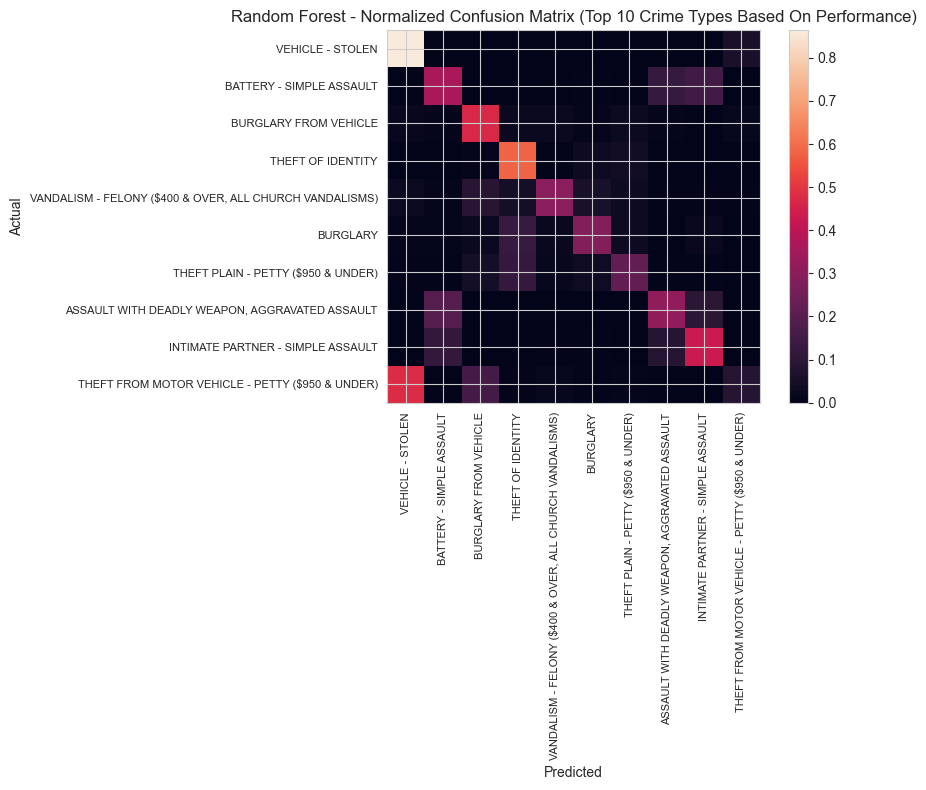


Classification report for top 10 crime types:

                                                         precision    recall  f1-score   support

                                       VEHICLE - STOLEN       0.75      0.86      0.80     23027
                               BATTERY - SIMPLE ASSAULT       0.40      0.36      0.38     14897
                                  BURGLARY FROM VEHICLE       0.44      0.47      0.45     12693
                                      THEFT OF IDENTITY       0.46      0.58      0.51     12500
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       0.54      0.30      0.39     12204
                                               BURGLARY       0.46      0.29      0.35     11570
                     THEFT PLAIN - PETTY ($950 & UNDER)       0.35      0.22      0.27     10718
         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.33      0.31      0.32     10701
                      INTIMATE PARTNER - SIMPLE ASSAULT       0.35      0.43  

In [50]:
# ===============================
# RANDOM FOREST EVALUATION
# ===============================

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Compute and print Accuracy and F1 scores
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_macro_f1 = f1_score(y_test, y_pred_rf, average='macro')

print("Random Forest Performance on Test Set")
print(f"Accuracy   : {rf_accuracy:.4f}")
print(f"Macro F1   : {rf_macro_f1:.4f}")

# Print classification report
print("\nClassification Report(Per Crime Type)")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# Plot and Display Confusion Matrix focusing on top 10 crime types
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_norm = cm_rf.astype('float') / cm_rf.sum(axis=1, keepdims=True)

top_n = 10
class_support_test = np.bincount(y_test, minlength=len(class_names))
top_indices = np.argsort(class_support_test)[::-1][:top_n]
cm_top = cm_rf_norm[np.ix_(top_indices, top_indices)]

# Corresponding crime type names
class_names_top = [class_names[i] for i in top_indices]

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(cm_top, interpolation='nearest')
plt.colorbar(im, ax=ax)

ax.set_xticks(np.arange(top_n))
ax.set_yticks(np.arange(top_n))

ax.set_xticklabels(class_names_top, rotation=90, fontsize=8)
ax.set_yticklabels(class_names_top, fontsize=8)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Random Forest - Normalized Confusion Matrix (Top {top_n} Crime Types Based On Performance)')

plt.tight_layout()
plt.show()

# Print a classification report corresponding to top 10 crimes
print(f"\nClassification report for top {top_n} crime types:\n")
print(classification_report(
    y_test,
    y_pred_rf,
    labels=top_indices,
    target_names=class_names_top
))